<a href="https://colab.research.google.com/github/miltondp/k99_courses/blob/main/cis_522/classes/01_17-week1/CIS_522_W1D1_Tutorial_%E2%80%93_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: PyTorch
**Week 1, Day 1: Basics and PyTorch**

**Created in cooperation with Neuromatch Academy**

__Content creators:__ Shubh Pachchigar, Vladimir Haltakov, Matthew Sargent, Konrad Kording

__Content reviewers:__ Deepak Raya, Siwei Bai, Kelson Shilling-Scrivo

__Content editors:__ Anoop Kulkarni, Spiros Chavlis, Ann-Katrin Reuel

__Production editors:__ Arush Tagade, Spiros Chavlis

In [37]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'miltondp' #@param {type:"string"}
my_pod = 'Factorial Ferrets' #@param ['Select', 'Factorial Ferrets', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = 'miltondp@gmail.com' #@param {type:"string"}
tutorial = 'W1D1'


# start timing
import time
try:t0;
except NameError: t0 = time.time()

---
# Tutorial Objectives

Then have a few specific objectives for this tutorial:
* Learn about PyTorch and tensors
* Tensor Manipulations
* Data Loading
* GPUs and Cuda Tensors
* Train NaiveNet
* Get to know your pod
* Start thinking about the course as a whole

---
# Setup

Throughout your tutorials, most (probably all!) notebooks contain setup cells. These cells will import the required Python packages (e.g., PyTorch, NumPy); set global or environment variables, and load in helper functions for things like plotting. In some tutorials, you will notice that we install some dependencies even if they are preinstalled on google colab or kaggle. This happens because we have added automation to our repository through [GitHub Actions](https://docs.github.com/en/actions/learn-github-actions/introduction-to-github-actions).

Be sure to run all of the cells in the setup section. Feel free to expand them and have a look at what you are loading in, but you should be able to fulfill the learning objectives of every tutorial without having to look at these cells.

If you start building your own projects built on this code base we highly recommend looking at them in more detail.

In [38]:
# @title Install dependencies
!pip install pandas --quiet
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm

  Preparing metadata (setup.py) ... done


In [39]:
# Imports
import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [40]:
# @title Figure Settings
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [41]:
# @title Helper Functions

atform = AirtableForm('appn7VdPRseSoMXEG','W1D1_T1','https://portal.neuromatchacademy.org/api/redirect/to/97e94a29-0b3a-4e16-9a8d-f6838a5bd83d')


def checkExercise1(A, B, C, D):
  """
  Helper function for checking exercise.

  Args:
    A: torch.Tensor
    B: torch.Tensor
    C: torch.Tensor
    D: torch.Tensor
  Returns:
    Nothing.
  """
  errors = []
  # TODO better errors and error handling
  if not torch.equal(A.to(int),torch.ones(20, 21).to(int)):
    errors.append(f"Got: {A} \n Expected: {torch.ones(20, 21)} (shape: {torch.ones(20, 21).shape})")
  if not np.array_equal( B.numpy(),np.vander([1, 2, 3], 4)):
    errors.append("B is not a tensor containing the elements of Z ")
  if C.shape != (20, 21):
    errors.append("C is not the correct shape ")
  if not torch.equal(D, torch.arange(4, 41, step=2)):
    errors.append("D does not contain the correct elements")

  if errors == []:
    print("All correct!")

  else:
    [print(e) for e in errors]


def timeFun(f, dim, iterations, device='cpu'):
  iterations = iterations
  t_total = 0
  for _ in range(iterations):
    start = time.time()
    f(dim, device)
    end = time.time()
    t_total += end - start

  if device == 'cpu':
    print(f"time taken for {iterations} iterations of {f.__name__}({dim}, {device}): {t_total:.5f}")
  else:
    print(f"time taken for {iterations} iterations of {f.__name__}({dim}, {device}): {t_total:.5f}")

**Important note: Google Colab users**

*Scratch Code Cells*

If you want to quickly try out something or take a look at the data you can use scratch code cells. They allow you to run Python code, but will not mess up the structure of your notebook.

To open a new scratch cell go to *Insert* → *Scratch code cell*.

# Section 1: Welcome to CIS522: Deep Learning!

In [6]:
#@title Video: Welcome to Week 1
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="jShhpc_5qLo", width=854, height=480, fs=1)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1])
out.set_title(0, 'Youtube')

display(out)

In [7]:
#@title Video: Standards for Conduct
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="iJ7mwRRgGSk", width=854, height=480, fs=1)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1])
out.set_title(0, 'Youtube')

display(out)

---
# Section 2: The Basics of PyTorch


PyTorch is a Python-based scientific computing package targeted at two sets of
audiences:

-  A replacement for NumPy to use the power of GPUs
-  A deep learning platform that provides significant flexibility
   and speed

At its core, PyTorch provides a few key features:

- A multidimensional [Tensor](https://pytorch.org/docs/stable/tensors.html) object, similar to [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) but with GPU acceleration.
- An optimized **autograd** engine for automatically computing derivatives.
- A clean, modular API for building and deploying **deep learning models**.

You can find more information about PyTorch in the appendix.

## Section 2.1: Creating Tensors


In [8]:
#@title Video: Making Tensors
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Rw411d7Uy", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"jGKd_4tPGrw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 3: Making Tensors')

display(out)

There are various ways of creating tensors, and when doing any real deep learning project we will usually have to do so.

**Construct tensors directly:**

---



In [9]:
# we can construct a tensor directly from some common python iterables,
# such as list and tuple nested iterables can also be handled as long as the
# dimensions make sense

# tensor from a list
a = torch.tensor([0, 1, 2])

#tensor from a tuple of tuples
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)

# tensor from a numpy array
c = np.ones([2, 3])
c = torch.tensor(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")

Tensor a: tensor([0, 1, 2])
Tensor b: tensor([[1.0000, 1.1000],
        [1.2000, 1.3000]])
Tensor c: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


**Some common tensor constructors:**

---

In [10]:
# the numerical arguments we pass to these constructors
# determine the shape of the output tensor

x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Tensor x: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Tensor y: tensor([0., 0.])
Tensor z: tensor([[[1.1827e-34, 0.0000e+00, 3.5032e-44, 0.0000e+00,        nan]]])


Notice that ```.empty()``` does not return zeros, but seemingly random small numbers. Unlike ```.zeros()```, which initialises the elements of the tensor with zeros, ```.empty()``` just allocates the memory. It is hence a bit faster if you are looking to just create a tensor.

**Creating random tensors and tensors like other tensors:**

---

In [11]:
# there are also constructors for random numbers

# uniform distribution
a = torch.rand(1, 3)

# normal distribution
b = torch.randn(3, 4)

# there are also constructors that allow us to construct
# a tensor according to the above constructors, but with
# dimensions equal to another tensor

c = torch.zeros_like(a)
d = torch.rand_like(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")
print(f"Tensor d: {d}")

Tensor a: tensor([[0.7038, 0.5317, 0.6464]])
Tensor b: tensor([[-2.4274, -1.2011,  0.4088, -0.2165],
        [-1.0915,  0.6051,  0.1696,  0.3800],
        [-0.7514,  1.8873, -0.8760,  0.5479]])
Tensor c: tensor([[0., 0., 0.]])
Tensor d: tensor([[0.0290, 0.8025, 0.7961]])


*Reproducibility*: 

- PyTorch random number generator: You can use `torch.manual_seed()` to seed the RNG for all devices (both CPU and CUDA)

```python
import torch
torch.manual_seed(0)
```
- For custom operators, you might need to set the Python seed as well:

```python
import random
random.seed(0)
```

- Random number generators in other libraries

```python
import numpy as np
np.random.seed(0)
```


Here, we define for you a function called `set_seed` that does the job for you!

In [12]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

Now, let's use the `set_seed` function in the previous example. Execute the cell multiple times to verify that the numbers printed are always the same.

In [13]:
def simplefun(seed=True, my_seed=None):
  if seed:
    set_seed(seed=my_seed)

  # uniform distribution
  a = torch.rand(1, 3)
  # normal distribution
  b = torch.randn(3, 4)

  print("Tensor a: ", a)
  print("Tensor b: ", b)

In [14]:
simplefun(seed=True, my_seed=0)  # Turn `seed` to `False` or change `my_seed`

Random seed 0 has been set.
Tensor a:  tensor([[0.4963, 0.7682, 0.0885]])
Tensor b:  tensor([[ 0.3643,  0.1344,  0.1642,  0.3058],
        [ 0.2100,  0.9056,  0.6035,  0.8110],
        [-0.0451,  0.8797,  1.0482, -0.0445]])


**Numpy-like number ranges:**
---
The ```.arange()``` and ```.linspace()``` behave how you would expect them to if you are familar with numpy.

In [15]:
a = torch.arange(0, 10, step=1)
b = np.arange(0, 10, step=1)

c = torch.linspace(0, 5, steps=11)
d = np.linspace(0, 5, num=11)

print(f"Tensor a: {a}\n")
print(f"Numpy array b: {b}\n")
print(f"Tensor c: {c}\n")
print(f"Numpy array d: {d}\n")

Tensor a: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Numpy array b: [0 1 2 3 4 5 6 7 8 9]

Tensor c: tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
        4.5000, 5.0000])

Numpy array d: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]



### Coding Exercise 2.1: Creating Tensors

Below you will find some incomplete code. Fill in the missing code to construct the specified tensors.

We want the tensors: 

$A:$ 20 by 21 tensor consisting of ones

$B:$ a tensor with elements equal to the elements of numpy array $Z$

$C:$ a tensor with the same number of elements as $A$ but with values $
\sim U(0,1)$

$D:$ a 1D tensor containing the even numbers between 4 and 40 inclusive.


In [16]:
def tensor_creation(Z):
  """A function that creates various tensors.

  Args:
    Z (numpy.ndarray): An array of shape

  Returns:
    A : 20 by 21 tensor consisting of ones
    B : a tensor with elements equal to the elements of numpy array  Z
    C : a tensor with the same number of elements as A but with values ∼U(0,1)
    D : a 1D tensor containing the even numbers between 4 and 40 inclusive.
  """
  #################################################
  ## TODO for students: fill in the missing code
  ## from the first expression
  #raise NotImplementedError("Student exercise: Please fill in the code in exercise 2.1!")
  #################################################
  A = torch.ones(20, 21)
  B = torch.from_numpy(Z)
  C = torch.rand(20, 21)
  D = torch.arange(4, 41, step=2)

  return A, B, C, D


# add timing to airtable
atform.add_event('Coding Exercise 2.1: Creating Tensors')



# numpy array to copy later
Z = np.vander([1, 2, 3], 4)

# Uncomment below to check your function!
A, B, C, D = tensor_creation(Z)
checkExercise1(A, B, C, D)

All correct!


## Section 2.2: Operations in PyTorch

**Tensor-Tensor operations**

We can perform operations on tensors using methods under ```torch.``` 



In [17]:
# @title Video: Tensor Operators
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1G44y127As", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"R1R8VoYXBVA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 4: Tensor Operators')

display(out)

**Tensor-Tensor operations**

We can perform operations on tensors using methods under ```torch.``` 

In [18]:
a = torch.ones(5, 3)
b = torch.rand(5, 3)
c = torch.empty(5, 3)
d = torch.empty(5, 3)

# this only works if c and d already exist
torch.add(a, b, out=c)
#Pointwise Multiplication of a and b
torch.multiply(a, b, out=d)
print(c)
print(d)

tensor([[1.6464, 1.5228, 1.0491],
        [1.9147, 1.7692, 1.9970],
        [1.7526, 1.1700, 1.9173],
        [1.5269, 1.7371, 1.0991],
        [1.3562, 1.0091, 1.3053]])
tensor([[0.6464, 0.5228, 0.0491],
        [0.9147, 0.7692, 0.9970],
        [0.7526, 0.1700, 0.9173],
        [0.5269, 0.7371, 0.0991],
        [0.3562, 0.0091, 0.3053]])


However, in PyTorch most common Python operators are overridden.
The common standard arithmetic operators (+, -, *, /, and **) have all been lifted to elementwise operations

In [19]:
x = torch.tensor([1, 2, 4, 8])
y = torch.tensor([1, 2, 3, 4])
x + y, x - y, x * y, x / y, x**y  # The ** operator is exponentiation

(tensor([ 2,  4,  7, 12]),
 tensor([0, 0, 1, 4]),
 tensor([ 1,  4, 12, 32]),
 tensor([1.0000, 1.0000, 1.3333, 2.0000]),
 tensor([   1,    4,   64, 4096]))

**Tensor Methods**

Tensors also have a number of common arithmetic operations built in. A full list of **all** methods can be found  in the appendix (there are a lot!) 

All of these operations should have similar syntax to their numpy equivalents.(Feel free to skip if you already know this!)

In [20]:
x = torch.rand(3, 3)
print(x)
print("\n")
# sum() - note the axis is the axis you move across when summing
print(f"Sum of every element of x: {x.sum()}")
print(f"Sum of the columns of x: {x.sum(axis=0)}")
print(f"Sum of the rows of x: {x.sum(axis=1)}")
print("\n")

print(f"Mean value of all elements of x {x.mean()}")
print(f"Mean values of the columns of x {x.mean(axis=0)}")
print(f"Mean values of the rows of x {x.mean(axis=1)}")

tensor([[0.6079, 0.1074, 0.6594],
        [0.7684, 0.5697, 0.1655],
        [0.1123, 0.3457, 0.7195]])


Sum of every element of x: 4.055744171142578
Sum of the columns of x: tensor([1.4886, 1.0228, 1.5443])
Sum of the rows of x: tensor([1.3747, 1.5035, 1.1776])


Mean value of all elements of x 0.4506382346153259
Mean values of the columns of x tensor([0.4962, 0.3409, 0.5148])
Mean values of the rows of x tensor([0.4582, 0.5012, 0.3925])


**Matrix Operations**

The ```@``` symbol is overridden to represent matrix multiplication. You can also use ```torch.matmul()``` to multiply tensors. For dot multiplication, you can use ```torch.dot()```, or manipulate the axes of your tensors and do matrix multiplication (we will cover that in the next section). 

Transposes of 2D tensors are obtained using ```torch.t()``` or ```Tensor.T```. Note the lack of brackets for ```Tensor.T``` - it is an attribute, not a method.

### Coding Exercise 2.2 : Simple tensor operations

Below are two expressions involving operations on matrices. 

$$ \textbf{A} = 
\begin{bmatrix}2 &4 \\5 & 7 
\end{bmatrix} 
\begin{bmatrix} 1 &1 \\2 & 3
\end{bmatrix} 
 + 
\begin{bmatrix}10 & 10  \\ 12 & 1 
\end{bmatrix} 
$$


and


$$ b = 
\begin{bmatrix} 3 \\ 5 \\ 7
\end{bmatrix} \cdot 
\begin{bmatrix} 2 \\ 4 \\ 8
\end{bmatrix}
$$

The code block below that computes these expressions using PyTorch is incomplete - fill in the missing lines.



In [21]:
def simple_operations(a1: torch.Tensor, a2: torch.Tensor, a3: torch.Tensor):
  ################################################
  ## TODO for students:  complete the first computation using the argument matricies
  #raise NotImplementedError("Student exercise: Fill in the missing code in exercise 2.2 to complete the operation")
  ################################################
  # multiplication of tensor a1 with tensor a2 and then add it with tensor a3
  answer = (a1 * a2) + a3
  return answer

# add timing to airtable
atform.add_event('Coding Exercise 2.2 : Simple tensor operations-simple_operations')

# Computing expression 1:

# init our tensors
a1 = torch.tensor([[2, 4], [5, 7]])
a2 = torch.tensor([[1, 1], [2, 3]])
a3 = torch.tensor([[10, 10], [12, 1]])
## uncomment to test your function
A = simple_operations(a1, a2, a3)
print(A)

tensor([[12, 14],
        [22, 22]])


In [22]:
def dot_product(b1: torch.Tensor, b2: torch.Tensor):
  ###############################################
  ## TODO for students:  complete the first computation using the argument matricies
  # raise NotImplementedError("Student exercise: fill in the missing code in exercise 2.2 to complete the operation")
  ###############################################
  # Use torch.dot() to compute the dot product of two tensors
  product = torch.dot(b1, b2)
  return product

# add timing to airtable
atform.add_event('Coding Exercise 2.2 : Simple tensor operations-dot_product')


# Computing expression 2:
b1 = torch.tensor([3, 5, 7])
b2 = torch.tensor([2, 4, 8])
## Uncomment to test your function
b = dot_product(b1, b2)
print(b)

tensor(82)


## Section 2.3 Manipulating Tensors in Pytorch



In [23]:
# @title Video: Tensor Indexing
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1BM4y1K7pD", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"0d0KSJ3lJbg", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 5: Tensor Indexing')

display(out)

**Indexing**

Just as in numpy, elements in a tensor can be accessed by index. As in any numpy array, the first element has index 0 and ranges are specified to include the first but before the last element. We can access elements according to their relative position to the end of the list by using negative indices. Indexing is also referred to as slicing.

For example, [-1] selects the last element; [1:3] selects the second and the third elements, and [:-2] will select all elements excluding the last and second-to-last elements.

In [24]:
x = torch.arange(0, 10)
print(x)
print(x[-1])
print(x[1:3])
print(x[:-2])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor(9)
tensor([1, 2])
tensor([0, 1, 2, 3, 4, 5, 6, 7])


When we have multidimensional tensors, indexing rules work the same way as numpy.

In [25]:
# make a 5D tensor
x = torch.rand(1, 2, 3, 4, 5)

print(f" shape of x[0]:{x[0].shape}")
print(f" shape of x[0][0]:{x[0][0].shape}")
print(f" shape of x[0][0][0]:{x[0][0][0].shape}")

 shape of x[0]:torch.Size([2, 3, 4, 5])
 shape of x[0][0]:torch.Size([3, 4, 5])
 shape of x[0][0][0]:torch.Size([4, 5])


**Flatten and reshape**

There are various methods for reshaping tensors. It is common to have to express 2D data in 1D format. Similarly, it is also common to have to reshape a 1D tensor into a 2D tensor. We can achieve this with the ```.flatten()``` and ```.reshape()``` methods.

In [26]:
z = torch.arange(12).reshape(6, 2)
print(f"Original z: \n {z}")

# 2D -> 1D
z = z.flatten()
print(f"Flattened z: \n {z}")

# and back to 2D
z = z.reshape(3, 4)
print(f"Reshaped (3x4) z: \n {z}")

Original z: 
 tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]])
Flattened z: 
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Reshaped (3x4) z: 
 tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


You will also see the ```.view()``` methods used a lot to reshape tensors. There is a subtle difference between ```.view()``` and ```.reshape()```, though for now we will just use ```.reshape()```. The documentation can be found in the appendix.

**Squeezing tensors**

When processing batches of data, you will quite often be left with singleton dimensions. e.g. [1,10] or [256, 1, 3]. This dimension can quite easily mess up your matrix operations if you don't plan on it being there...

In order to compress tensors along their singleton dimensions we can use the ```.squeeze()``` method. We can use the ```.unsqueeze()``` method to do the opposite. 


In [27]:
x = torch.randn(1, 10)
# printing the zeroth element of the tensor will not give us the first number!

print(x.shape)
print(f"x[0]: {x[0]}")

torch.Size([1, 10])
x[0]: tensor([-1.6057,  0.2758, -0.0624, -1.5593, -0.8883, -0.7485,  0.1456, -0.6005,
         0.8546,  1.1705])


 Because of that pesky singleton dimension, x[0] gave us the first row instead!



In [28]:
# lets get rid of that singleton dimension and see what happens now
x = x.squeeze(0)
print(x.shape)
print(f"x[0]: {x[0]}")

torch.Size([10])
x[0]: -1.6056749820709229


In [29]:
# adding singleton dimensions works a similar way, and is often used when tensors
# being added need same number of dimensions

y = torch.randn(5, 5)
print(f"shape of y: {y.shape}")

# lets insert a singleton dimension
y = y.unsqueeze(0)
print(f"shape of y: {y.shape}")

shape of y: torch.Size([5, 5])
shape of y: torch.Size([1, 5, 5])


**Permutation**
Sometimes our dimensions will be in the wrong order! For example, we may be dealing with RGB images with dim [3x48x64], but our pipeline expects the colour dimension to be the last dimension i.e. [48x64x3]. To get around this we can use ```.permute()```


In [30]:
# `x` has dimensions [color,image_height,image_width]
x = torch.rand(3, 48, 64)

# we want to permute our tensor to be [ image_height , image_width , color ]
x = x.permute(1, 2, 0)
# permute(1,2,0) means:
# the 0th dim of my new tensor = the 1st dim of my old tensor
# the 1st dim of my new tensor = the 2nd
# the 2nd dim of my new tensor = the 0th
print(x.shape)

torch.Size([48, 64, 3])


You may also see ```.transpose()``` used. This works in a similar way as permute, but can only swap two dimensions at once.

**Concatenation**

In this example, we concatenate two matrices along rows (axis 0, the first element of the shape) vs. columns (axis 1, the second element of the shape). We can see that the first output tensor’s axis-0 length ( 6 ) is the sum of the two input tensors’ axis-0 lengths ( 3+3 ); while the second output tensor’s axis-1 length ( 8 ) is the sum of the two input tensors’ axis-1 lengths ( 4+4 ).

In [31]:
# Create two tensors of the same shape
x = torch.arange(12, dtype=torch.float32).reshape((3, 4))
y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])


#concatenate them along rows
cat_rows = torch.cat((x, y), dim=0)

# concatenate along columns
cat_cols = torch.cat((x, y), dim=1)

# printing outputs
print('Concatenated by rows: shape{} \n {}'.format(list(cat_rows.shape), cat_rows))
print('\n Concatenated by colums: shape{}  \n {}'.format(list(cat_cols.shape), cat_cols))

Concatenated by rows: shape[6, 4] 
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [ 2.,  1.,  4.,  3.],
        [ 1.,  2.,  3.,  4.],
        [ 4.,  3.,  2.,  1.]])

 Concatenated by colums: shape[3, 8]  
 tensor([[ 0.,  1.,  2.,  3.,  2.,  1.,  4.,  3.],
        [ 4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.],
        [ 8.,  9., 10., 11.,  4.,  3.,  2.,  1.]])


**Conversion to Other Python Objects**

Converting to a NumPy tensor, or vice versa, is easy. The converted result does not share memory. This minor inconvenience is actually quite important: when you perform operations on the CPU or on GPUs, you do not want to halt computation, waiting to see whether the NumPy package of Python might want to be doing something else with the same chunk of memory.

When converting to a numpy array, the information being tracked by the tensor will be lost i.e. the computational graph. This will be covered in detail when you are introduced to autograd tomorrow! 

In [32]:
x = torch.randn(5)
print(f"x: {x}  |  x type:  {x.type()}")

y = x.numpy()
print(f"y: {y}  |  y type:  {type(y)}")

z = torch.tensor(y)
print(f"z: {z}  |  z type:  {z.type()}")

x: tensor([-2.2472,  0.2189, -0.6323,  0.9613,  0.5662])  |  x type:  torch.FloatTensor
y: [-2.2472162   0.21886738 -0.6322729   0.96129405  0.5662092 ]  |  y type:  <class 'numpy.ndarray'>
z: tensor([-2.2472,  0.2189, -0.6323,  0.9613,  0.5662])  |  z type:  torch.FloatTensor


To convert a size-1 tensor to a Python scalar, we can invoke the item function or Python’s built-in functions.

In [33]:
a = torch.tensor([3.5])
a, a.item(), float(a), int(a)

(tensor([3.5000]), 3.5, 3.5, 3)

### Coding Exercise 2.3: Manipulating Tensors
Using a combination of the methods discussed above, complete the functions below.

**Function A** 

This function takes in two 2D tensors $A$ and $B$ and returns the column sum of A multiplied by the sum of all the elmements of $B$ i.e. a scalar, e.g.,:

$ A = \begin{bmatrix}
1 & 1 \\
1 & 1 
\end{bmatrix} \,$
and
$ B = \begin{bmatrix}
1 & 2 & 3\\
1 & 2 & 3 
\end{bmatrix} \,$
so
$ \, Out =  \begin{bmatrix} 2 & 2 \\
\end{bmatrix} \cdot 12 = \begin{bmatrix}
24 & 24\\
\end{bmatrix}$

**Function B** 

This function takes in a square matrix $C$ and returns a 2D tensor consisting of a flattened $C$ with the index of each element appended to this tensor in the row dimension, e.g.,:

$ C = \begin{bmatrix}
2 & 3 \\
-1 & 10 
\end{bmatrix} \,$
so
$ \, Out = \begin{bmatrix}
0 & 2 \\
1 & 3 \\
2 & -1 \\
3 & 10
\end{bmatrix}$

**Hint:** pay close attention to singleton dimensions

**Function C**

This function takes in two 2D tensors $D$ and $E$. If the dimensions allow it, this function returns the elementwise sum of $D$-shaped $E$, and $D$; else this function returns a 1D tensor that is the concatenation of the two tensors, e.g.,:

$ D = \begin{bmatrix}
1 & -1 \\
-1 & 3 
\end{bmatrix} \,$
and 
$ E = \begin{bmatrix}
2 & 3 & 0 & 2 \\
\end{bmatrix} \, $
so
$ \, Out = \begin{bmatrix}
3 & 2 \\
-1 & 5 
\end{bmatrix}$

$ D = \begin{bmatrix}
1 & -1 \\
-1 & 3 
\end{bmatrix}$
and
$ \, E = \begin{bmatrix}
2 & 3 & 0  \\
\end{bmatrix} \,$
so
$ \, Out = \begin{bmatrix}
1 & -1 & -1 & 3  & 2 & 3 & 0  
\end{bmatrix}$

**Hint:** `torch.numel()` is an easy way of finding the number of elements in a tensor


In [34]:
def functionA(my_tensor1, my_tensor2):
  """
  This function takes in two 2D tensors `my_tensor1` and `my_tensor2`
  and returns the column sum of
  `my_tensor1` multiplied by the sum of all the elmements of `my_tensor2`,
  i.e., a scalar.

  Args:
    my_tensor1: torch.Tensor
    my_tensor2: torch.Tensor
  Retuns:
    output: torch.Tensor
      The multiplication of the column sum of `my_tensor1` by the sum of
      `my_tensor2`.
  """
  ################################################
  ## TODO for students: complete functionA
  #raise NotImplementedError("Student exercise: complete function A")
  ################################################
  # TODO multiplication the sum of the tensors
  output = my_tensor1.sum(axis=0) * my_tensor2.sum()

  return output


def functionB(my_tensor):
  """
  This function takes in a square matrix `my_tensor` and returns a 2D tensor
  consisting of a flattened `my_tensor` with the index of each element
  appended to this tensor in the row dimension.

  Args:
    my_tensor: torch.Tensor
  Retuns:
    output: torch.Tensor
      Concatenated tensor.
  """
  ################################################
  ## TODO for students: complete functionB
  # raise NotImplementedError("Student exercise: complete function B")
  ################################################
  # TODO flatten the tensor `my_tensor`
  my_tensor = my_tensor.flatten().unsqueeze(1)
  # TODO create the idx tensor to be concatenated to `my_tensor`
  idx_tensor = torch.arange(0, my_tensor.shape[0]).unsqueeze(1)
  # TODO concatenate the two tensors
  output = torch.cat((idx_tensor, my_tensor), dim=1)
  # output = torch.tensor([idx_tensor.squeeze(), my_tensor.squeeze()]).T

  return output


def functionC(my_tensor1, my_tensor2):
  """
  This function takes in two 2D tensors `my_tensor1` and `my_tensor2`.
  If the dimensions allow it, it returns the
  elementwise sum of `my_tensor1`-shaped `my_tensor2`, and `my_tensor2`;
  else this function returns a 1D tensor that is the concatenation of the
  two tensors.

  Args:
    my_tensor1: torch.Tensor
    my_tensor2: torch.Tensor
  Retuns:
    output: torch.Tensor
      Concatenated tensor.
  """
  ################################################
  ## TODO for students: complete functionB
  # raise NotImplementedError("Student exercise: complete function C")
  ################################################
  # TODO check we can reshape `my_tensor2` into the shape of `my_tensor1`
  if my_tensor1.numel() == my_tensor2.numel():
    # TODO reshape `my_tensor2` into the shape of `my_tensor1`
    my_tensor2 = my_tensor2.reshape(my_tensor1.shape)
    # TODO sum the two tensors
    output = my_tensor1 + my_tensor2
  else:
    # TODO flatten both tensors
    my_tensor1 = my_tensor1.flatten().unsqueeze(0)
    my_tensor2 = my_tensor2.flatten().unsqueeze(0)
    # TODO concatenate the two tensors in the correct dimension
    output = torch.cat((my_tensor1, my_tensor2), dim=1)

  return output

# add timing to airtable
atform.add_event('Coding Exercise 2.3: Manipulating Tensors')



## Implement the functions above and then uncomment the following lines to test your code
print(functionA(torch.tensor([[1, 1], [1, 1]]), torch.tensor([[1, 2, 3], [1, 2, 3]])))
print(functionB(torch.tensor([[2, 3], [-1, 10]])))
print(functionC(torch.tensor([[1, -1], [-1, 3]]), torch.tensor([[2, 3, 0, 2]])))
print(functionC(torch.tensor([[1, -1], [-1, 3]]), torch.tensor([[2, 3, 0]])))

tensor([24, 24])
tensor([[ 0,  2],
        [ 1,  3],
        [ 2, -1],
        [ 3, 10]])
tensor([[ 3,  2],
        [-1,  5]])
tensor([[ 1, -1, -1,  3,  2,  3,  0]])


## Section 2.4: GPUs 


In [35]:
# @title Video: GPU vs CPU
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1nM4y1K7qx", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"9Mc9GFUtILY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 6: GPU vs CPU')

display(out)


By default, when we create a tensor it will *not* live on the GPU! 

In [36]:
x = torch.randn(10)
print(x.device)

cpu


When using Colab notebooks by default will not have access to a GPU. In order to start using GPUs we need to request one. We can do this by going to the runtime tab at the top of the page. 

By following Runtime -> Change runtime type and selecting "GPU" from the Hardware Accelerator dropdown list, we can start playing with sending tensors to GPUs.

Once you have done this your runtime will restart and you will need to rerun the first setup cell to reimport PyTorch. Then proceed to the next cell.

(For more information on the GPU usage policy you can view in the appendix)

**Now we have a GPU**


The cell below should return True.

In [42]:
print(torch.cuda.is_available())

True


CUDA is an API developed by Nvidia for interfacing with GPUs. PyTorch provides us with a layer of abstraction, and allows us to launch CUDA kernels using pure Python. *NOTE I am assuming that GPU stuff might be covered in more detail on another day but there could be a bit more detail here.*

In short, we get the power of parallising our tensor computations on GPUs, whilst only writing (relatively) simple Python!

Here, we define the function `set_device`, which returns the device use in the notebook, i.e., `cpu` or `cuda`. Unless otherwise specified, we use this function on top of every tutorial, and we store the device variable such as

```python
DEVICE = set_device()
```

Let's define the function using the PyTorch package `torch.cuda`, which is lazily initialized, so we can always import it, and use `is_available()` to determine if our system supports CUDA.

In [43]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

Let's make some CUDA tensors!

In [44]:
# common device agnostic way of writing code that can run on cpu OR gpu
# that we provide for you in each of the tutorials
DEVICE = set_device()

# we can specify a device when we first create our tensor
x = torch.randn(2, 2, device=DEVICE)
print(x.dtype)
print(x.device)

# we can also use the .to() method to change the device a tensor lives on
y = torch.randn(2, 2)
print(f"y before calling to() |  device: {y.device} | dtype: {y.type()}")

y = y.to(DEVICE)
print(f"y after calling to() |  device: {y.device} | dtype: {y.type()}")

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
torch.float32
cuda:0
y before calling to() |  device: cpu | dtype: torch.FloatTensor
y after calling to() |  device: cuda:0 | dtype: torch.cuda.FloatTensor


**Operations between cpu tensors and cuda tensors**

Note that the type of the tensor changed after calling ```.to()```. What happens if we try and perform operations on tensors on devices?




In [45]:
x = torch.tensor([0, 1, 2], device=DEVICE)
y = torch.tensor([3, 4, 5], device="cpu")

# Uncomment the following line and run this cell
#z = x + y

We cannot combine cuda tensors and cpu tensors in this fashion. If we want to compute an operation that combines tensors on different devices, we need to move them first! We can use the `.to()` method as before, or the `.cpu()` and `.cuda()` methods. Note that using the `.cuda()` will throw an error if CUDA is not enabled in your machine.

Genrally in this course all Deep learning is done on the GPU and any computation is done on the CPU, so sometimes we have to pass things back and forth so you'll see us call.

In [46]:
x = torch.tensor([0, 1, 2], device=DEVICE)
y = torch.tensor([3, 4, 5], device="cpu")
z = torch.tensor([6, 7, 8], device=DEVICE)

# moving to cpu
x = x.to("cpu")  # alternatively, you can use x = x.cpu()
print(x + y)

# moving to gpu
y = y.to(DEVICE)  # alternatively, you can use y = y.cuda()
print(y + z)

tensor([3, 5, 7])
tensor([ 9, 11, 13], device='cuda:0')


### Coding Exercise 2.4: Just how much faster are GPUs?

Below is a simple function `simpleFun`. Complete this function, such that it performs the operations:

- elementwise multiplication

- matrix multiplication

The operations should be able to perfomed on either the CPU or GPU specified by the parameter `device`. We will use the helper function `timeFun(f, dim, iterations, device)`.

In [47]:
dim = 10000
iterations = 1

In [48]:
def simpleFun(dim, device):
  """
  Args:
    dim: integer
    device: "cpu" or "cuda"
  Returns:
    Nothing.
  """
  ###############################################
  ## TODO for students: recreate the function, but
  ## ensure all computations happens on the `device`
  #raise NotImplementedError("Student exercise: fill in the missing code to create the tensors")
  ###############################################
  # 2D tensor filled with uniform random numbers in [0,1), dim x dim
  x = torch.rand(dim, dim, device=device)
  # 2D tensor filled with uniform random numbers in [0,1), dim x dim
  y = torch.rand(dim, dim, device=device)
  # 2D tensor filled with the scalar value 2, dim x dim
  z = torch.zeros(dim, dim) + 2

  # elementwise multiplication of x and y
  a = x * y
  # matrix multiplication of x and y
  b = x @ y

  del x
  del y
  del z
  del a
  del b


## TODO: Implement the function above and uncomment the following lines to test your code
timeFun(f=simpleFun, dim=dim, iterations=iterations)
timeFun(f=simpleFun, dim=dim, iterations=iterations, device=DEVICE)

time taken for 1 iterations of simpleFun(10000, cpu): 17.51714
time taken for 1 iterations of simpleFun(10000, cuda): 2.34389


## Section 2.5: Datasets and Dataloaders



In [49]:
# @title Video: Getting Data
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1744y127SQ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"LSkjPM1gFu0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 7: Getting Data')

display(out)

When training neural network models you will be working with large amounts of data. Fortunately, PyTorch offers some great tools that help you organize and manipulate your data samples.


In [50]:
# Import dataset and dataloaders related packages
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale

**Datasets**

The `torchvision` package gives you easy access to many of the publicly available datasets. Let's load the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which contains color images of 10 different classes, like vehicles and animals.

Creating an object of type `datasets.CIFAR10` will automatically download and load all images from the dataset. The resulting data structure can be treated as a list containing data samples and their corresponding labels.

In [51]:
# Download and load the images from the CIFAR10 dataset
cifar10_data = datasets.CIFAR10(
    root="data",            # path where the images will be stored
    download=True,          # all images should be downloaded
    transform=ToTensor()    # transform the images to tensors
    )

# Print the number of samples in the loaded dataset
print(f"Number of samples: {len(cifar10_data)}")
print(f"Class names: {cifar10_data.classes}")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Number of samples: 50000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We have 50000 samples loaded. Now let's take a look at one of them in detail. Each sample consists of an image and its corresponding label.

In [52]:
# Choose a random sample
random.seed(2021)
image, label = cifar10_data[random.randint(0, len(cifar10_data))]
print(f"Label: {cifar10_data.classes[label]}")
print(f"Image size: {image.shape}")

Label: horse
Image size: torch.Size([3, 32, 32])


Color images are modeled as 3 dimensional tensors. The first dimension corresponds to the channels (C) of the image (in this case we have RGB images). The second dimensions is the height (H) of the image and the third is the width (W). We can denote this image format as C × H × W.

### Coding Exercise 2.5: Display an image from the dataset

Let's try to display the image using `matplotlib`. The code below will not work, because `imshow` expects to have the image in a different format - $H \times W \times C$.

You need to reorder the dimensions of the tensor using the `permute` method of the tensor. PyTorch `torch.permute(*dims)` rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor. The size of the returned tensor remains the same as that of the original.

**Code hint:**

```python
# create a tensor of size 2 x 4
input_var = torch.randn(2, 4)
# print its size and the tensor
print(input_var.size())
print(input_var)

# dimensions permuted
input_var = input_var.permute(1, 0)
# print its size and the permuted tensor
print(input_var.size())
print(input_var)
```

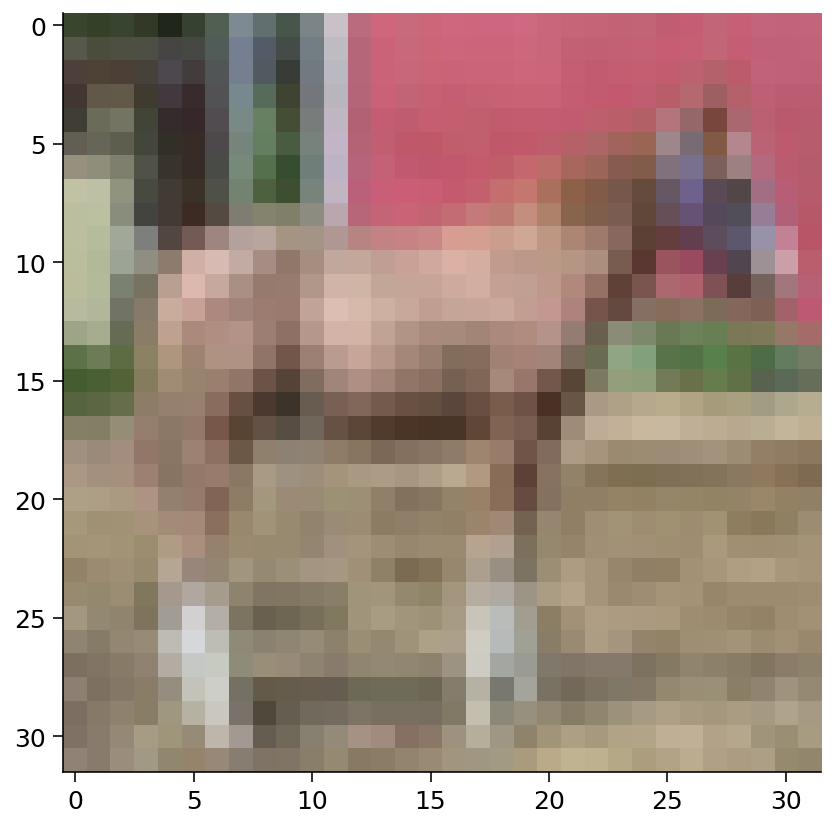

In [53]:
# TODO: Uncomment the following line to see the error that arises from the current image format
# plt.imshow(image)

# TODO: Comment the above line and fix this code by reordering the tensor dimensions
plt.imshow(image.permute(1,2,0))
plt.show()

In [ ]:
#@title Video: Train and Test
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1rV411H7s5", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"JokSIuPs-ys", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 8: Train and Test')

display(out)

**Training and Test Datasets**

When loading a dataset, you can specify if you want to load the training or the test samples using the `train` argument. We can load the training and test datasets separately. For simplicity, today we will not use both datasets separately, but this topic will be adressed in the next days.

In [54]:
# Load the training samples
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

# Load the test samples
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
    )

Files already downloaded and verified
Files already downloaded and verified


In [55]:
# @title Video: Data Augmentation - Transformations
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV19B4y1N77t", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"sjegA9OBUPw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 9: Data Augmentation - Transformations')

display(out)

**Dataloader**

Another important concept is the `Dataloader`. It is a wrapper around the `Dataset` that splits it into minibatches (important for training the neural network) and makes the data iterable. The `shuffle` argument is used to shuffle the order of the samples across the minibatches.


In [56]:
# Create dataloaders with
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

*Reproducibility:* DataLoader will reseed workers following Randomness in multi-process data loading algorithm. Use `worker_init_fn()` and a `generator` to preserve reproducibility:


```python
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  random.seed(worker_seed)


g_seed = torch.Generator()
g_seed.manual_seed(my_seed)

DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g_seed
    )
```

**Note:** For the `seed_worker` to have an effect, `num_workers` should be 2 or more.

We can now query the next batch from the data loader and inspect it. For this we need to convert the dataloader object to a Python iterator using the function `iter` and then we can query the next batch using the function `next`.

We can now see that we have a 4D tensor. This is because we have a 64 images in the batch ($B$) and each image has 3 dimensions: channels ($C$), height ($H$) and width ($W$). So, the size of the 4D tensor is $B \times C \times H \times W$.

Batch size: torch.Size([64, 3, 32, 32])


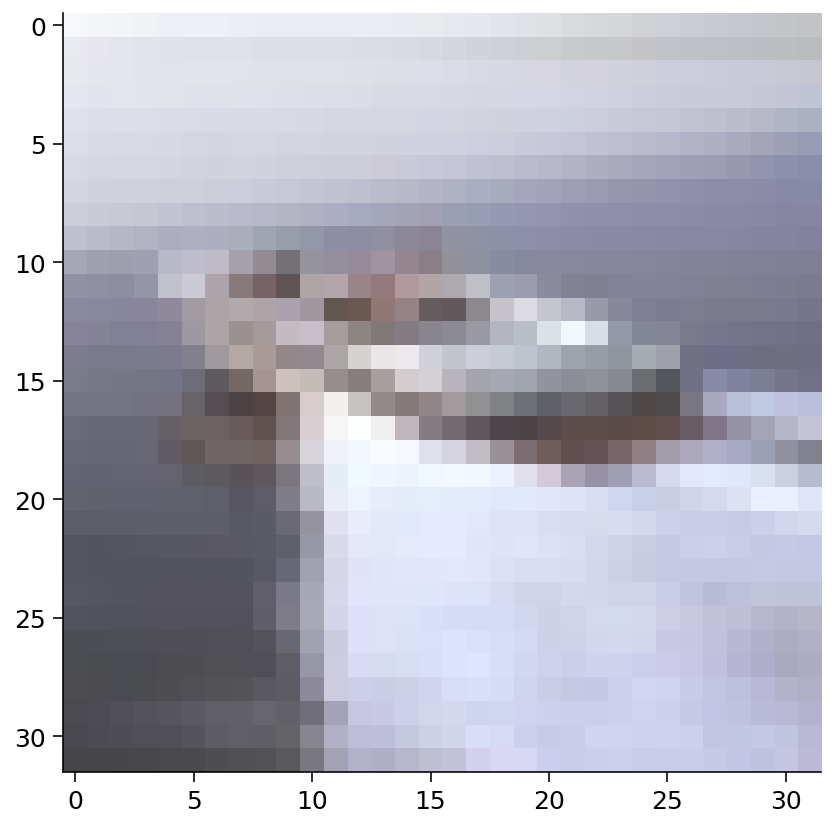

In [57]:
# Load the next batch
batch_images, batch_labels = next(iter(train_dataloader))
print('Batch size:', batch_images.shape)

# Display the first image from the batch
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()

**Transformations**

Another useful feature when loading a dataset is applying transformations on the data - color conversions, normalization, cropping, rotation etc. There are many predefined transformations in the `torchvision.transforms` package and you can also combine them using the `Compose` transform. Checkout the [pytorch documentation](https://pytorch.org/vision/stable/transforms.html) for details.

### Coding Exercise 2.6: Load the CIFAR10 dataset as grayscale images

The goal of this excercise is to load the images from the CIFAR10 dataset as grayscale images. Note that we rerun the `set_seed` function to ensure reproducibility.

Random seed 2021 has been set.
Files already downloaded and verified


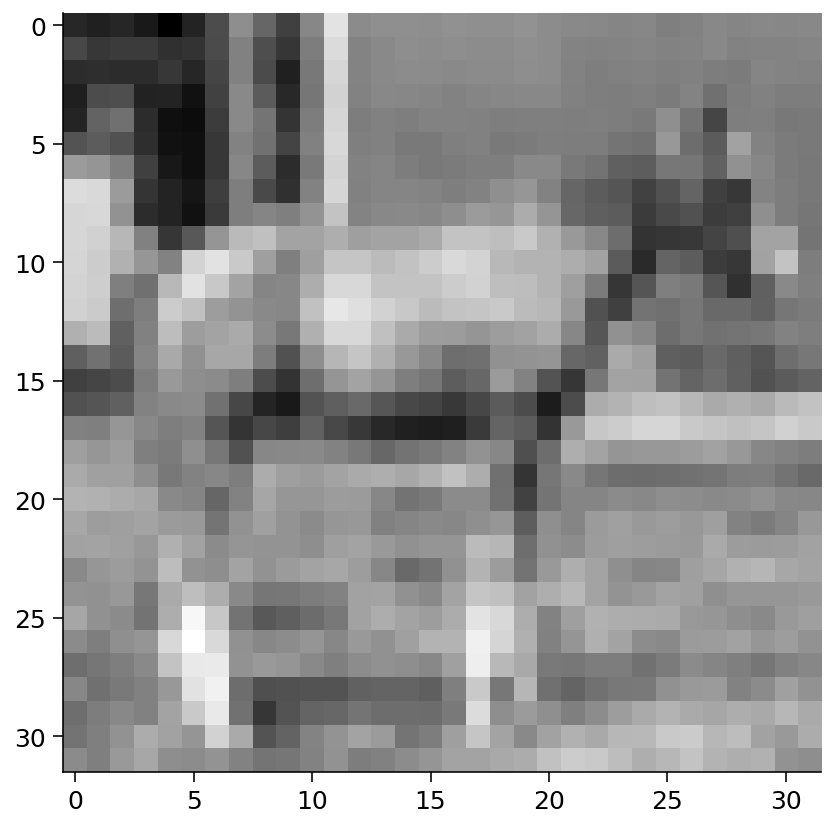

In [58]:
def my_data_load():
  ###############################################
  ## TODO for students: load the CIFAR10 data,
  ## but as grayscale images and not as RGB colored.
  #raise NotImplementedError("Student exercise: fill in the missing code to load the data")
  ###############################################
  ## TODO Load the CIFAR10 data using a transform that converts the images to grayscale tensors
  data = datasets.CIFAR10(
    root="data",
    # train=True,
    download=True,
    transform=Compose([Grayscale(), ToTensor()]),
  )
  # Display a random grayscale image
  image, label = data[random.randint(0, len(data))]
  plt.imshow(image.squeeze(), cmap="gray")
  plt.show()

  return data


set_seed(seed=2021)
## After implementing the above code, uncomment the following lines to test your code
data = my_data_load()

---
# Section 3: Neural Networks

Now it's time for you to create your first neural network using PyTorch. This section will walk you through the process of:
- Creating a simple neural network model
- Training the network
- Visualizing the results of the network
- Tweeking the network

In [59]:
# @title Video 10: CSV Files
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1xy4y1T7kv", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"JrC_UAJWYKU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 10: CSV Files')

display(out)

## Section 3.1: Data Loading

First we need some sample data to train our network on. You can use the function below to generate an example dataset consisting of 2D points along two interleaving half circles. The data will be stored in a file called `sample_data.csv`. You can inspect the file directly in Colab by going to Files on the left side and opening the CSV file.

In [60]:
# @title Generate sample data
# @markdown we used `scikit-learn` module
from sklearn.datasets import make_moons

# Create a dataset of 256 points with a little noise
X, y = make_moons(256, noise=0.1)

# Store the data as a Pandas data frame and save it to a CSV file
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], y=y))
df.to_csv('sample_data.csv')

Now we can load the data from the CSV file using the Pandas library. Pandas provides many functions for reading files in various formats. When loading data from a CSV file, we can reference the columns directly by their names.

Size X:(256, 2)
Size y:(256,)


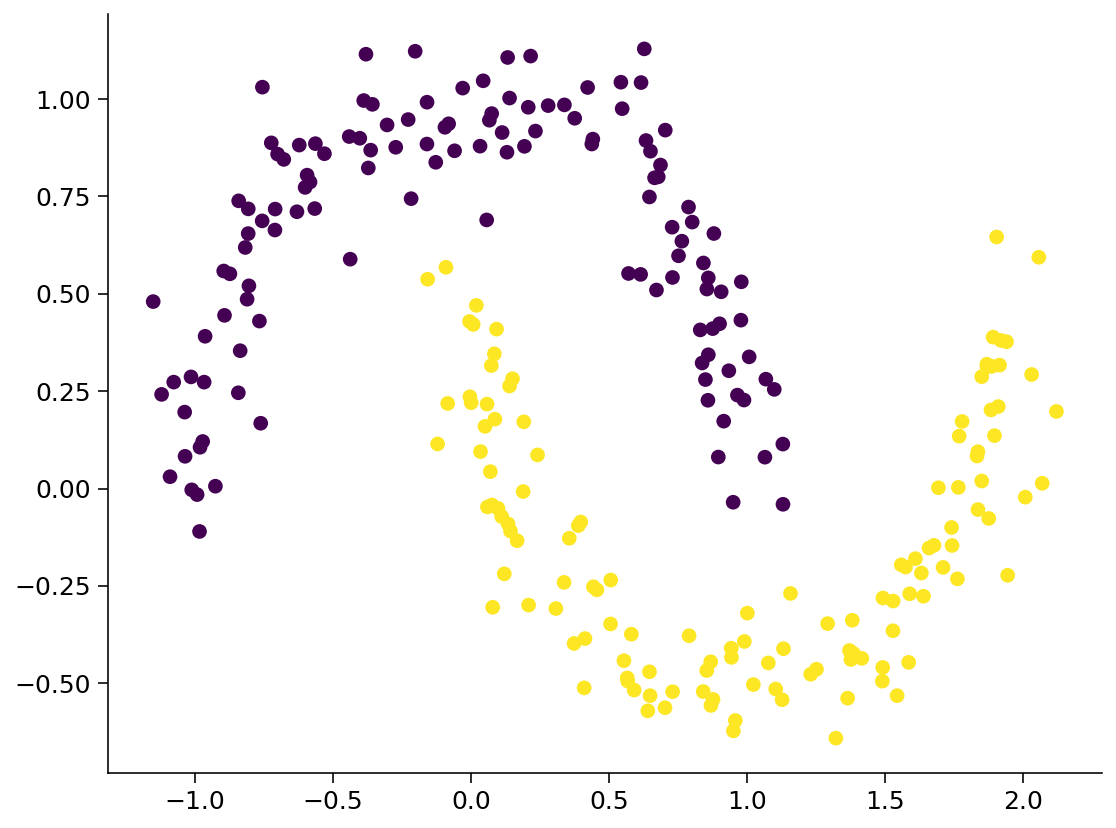

In [61]:
# Load the data from the CSV file in a Pandas DataFrame
data = pd.read_csv("sample_data.csv")

# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0", "x1"]].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")

# Visualize the dataset. The color of the points is determined by the labels `y_orig`.
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
plt.show()

**Prepare Data for PyTorch**

Now let's prepare the data in a format suitable for PyTorch - convert everything into tensors.

In [62]:
# Initialize the device variable
DEVICE = set_device()

# Convert the 2D points to a float32 tensor
X = torch.tensor(X_orig, dtype=torch.float32)

# Upload the tensor to the device
X = X.to(DEVICE)

print(f"Size X:{X.shape}")

# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)
# Upload the tensor to the device
y = y.to(DEVICE)

print(f"Size y:{y.shape}")

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Size X:torch.Size([256, 2])
Size y:torch.Size([256])


## Section 3.2: Create a Simple Neural Network

In [ ]:
# @title Video: Generating the Neural Network
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1fK4y1M74a", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"PwSzRohUvck", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 11: Generating the Neural Network')

display(out)

For this example we want to have a simple neural network consisting of 3 layers:
- 1 input layer of size 2 (our points have 2 coordinates)
- 1 hidden layer of size 16 (you can play with different numbers here)
- 1 output layer of size 2 (we want the have the scores for the two classes)

During the course you will deal with differend kinds of neural networks. The example here is meant to demonstrate the process of creating and training a neural network end-to-end.

**Programing the Network**

PyTorch provides a base class for all neural network modules called [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). You need to inherit from `nn.Module` and implement some important methods:

`__init__`

In the `__init__` method you need to define the structure of your network. Here you will specify what layers will the network consist of, what activation functions will be used etc.

`forward`

All neural network modules need to implement the `forward` method. It specifies the computations the network needs to do when data is passed through it.

`predict`

This is not an obligatory method of a neural network module, but it is a good practice if you want to quickly get the most likely label from the network. It calls the `forward` method and chooses the label with the highest score.

`train`

This is also not an obligatory method, but it is a good practice to have. The method will be used to train the network parameters and will be implemented later in the notebook.


> Note that you can use the `__call__` method of a module directly and it will invoke the `forward` method: `net()` does the same as `net.forward()`.

In [84]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class NaiveNet(nn.Module):

  # Define the structure of your network
  def __init__(self):
    super(NaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(2, 16),  # Transformation from the input to the hidden layer
        nn.ReLU(),         # Activation function (ReLU) is a non-linearity which
                           # is widely used because it reduces computation. The
                           # function returns 0 if it receives any
                           # negative input, but for any positive value x, it
                           # returns that value back.
        nn.Linear(16, 2),  # Transformation from the hidden to the output layer
    )

  # Specify the computations performed on the data
  def forward(self, x):
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

  # Train the neural network (will be implemented later)
  def train(self, X, y):
    pass

**Check that your network works**

Create an instance of your model and visualize it

In [85]:
# Create new NaiveNet and transfer it to the device
model = NaiveNet().to(DEVICE)

# Print the structure of the network
print(model)

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


### Coding Exercise 3.2: Classify some samples

Now let's pass some of the points of our dataset through the network and see if it works. You should not expect the network to actually classify the points correctly, because it has not been trained yet. 

The goal here is just to get some experience with the data structures that are passed to the forward and predict methods and their results.

In [101]:
## Get the samples
idx = np.random.choice(X.shape[0], size=10)
X_samples = X[idx]
print("Sample input:\n", X_samples)

## Do a forward pass of the network
output = model.forward(X_samples)
print("\nNetwork output:\n", output)

## Predict the label of each point
y_predicted = model.predict(X_samples)
print("\nPredicted labels:\n", y_predicted)

Sample input:
 tensor([[ 1.8372, -0.0538],
        [ 1.1044, -0.5146],
        [-0.8963,  0.5586],
        [ 0.0664,  0.9456],
        [ 0.9439, -0.4332],
        [ 0.2795,  0.9832],
        [-0.8935,  0.4447],
        [ 0.8962,  0.0810],
        [ 0.2335,  0.9177],
        [ 1.1301,  0.1142]], device='cuda:0')

Network output:
 tensor([[-0.8508,  0.8901],
        [-0.6256,  0.6180],
        [-0.2819,  0.4943],
        [-0.6158,  0.7938],
        [-0.6072,  0.6035],
        [-0.6652,  0.8373],
        [-0.2606,  0.4627],
        [-0.6921,  0.7183],
        [-0.6514,  0.8091],
        [-0.7463,  0.7736]], device='cuda:0', grad_fn=<AddmmBackward0>)

Predicted labels:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


## Section 3.3: Train Your Neural Network



In [ ]:
# @title Video: Train the Network
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1v54y1n7CS", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"4MIqnE4XPaA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 12: Train the Network')

display(out)

Now it is time to train your network on your dataset. Don't worry if you don't fully understand everything yet - we will cover training in much more details in the next days. For now, the goal is just to see your network in action!

You will usually implement the `train` method directly when implementing your class `NaiveNet`. Here, we will implement it as a function outside of the class in order to have it in a ceparate cell.

In [103]:
# @title Helper function to plot the decision boundary

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/

from pathlib import Path

def plot_decision_boundary(model, X, y, device):
  # Transfer the data to the CPU
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Check if the frames folder exists and create it if needed
  frames_path = Path("frames")
  if not frames_path.exists():
    frames_path.mkdir()

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Predict the function value for the whole gid
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
  Z = model.predict(grid_points.to(device)).cpu().numpy()
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

Epoch 0 loss is 0.7168161273002625
Epoch 1000 loss is 0.29757317900657654
Epoch 2000 loss is 0.25838878750801086
Epoch 3000 loss is 0.24884454905986786
Epoch 4000 loss is 0.24096542596817017
Epoch 5000 loss is 0.23127815127372742
Epoch 6000 loss is 0.21969957649707794
Epoch 7000 loss is 0.20424911379814148
Epoch 8000 loss is 0.18566033244132996
Epoch 9000 loss is 0.1669849008321762
Epoch 10000 loss is 0.1496734917163849
Epoch 11000 loss is 0.1336245834827423
Epoch 12000 loss is 0.1191568598151207
Epoch 13000 loss is 0.10627821087837219
Epoch 14000 loss is 0.09506282955408096


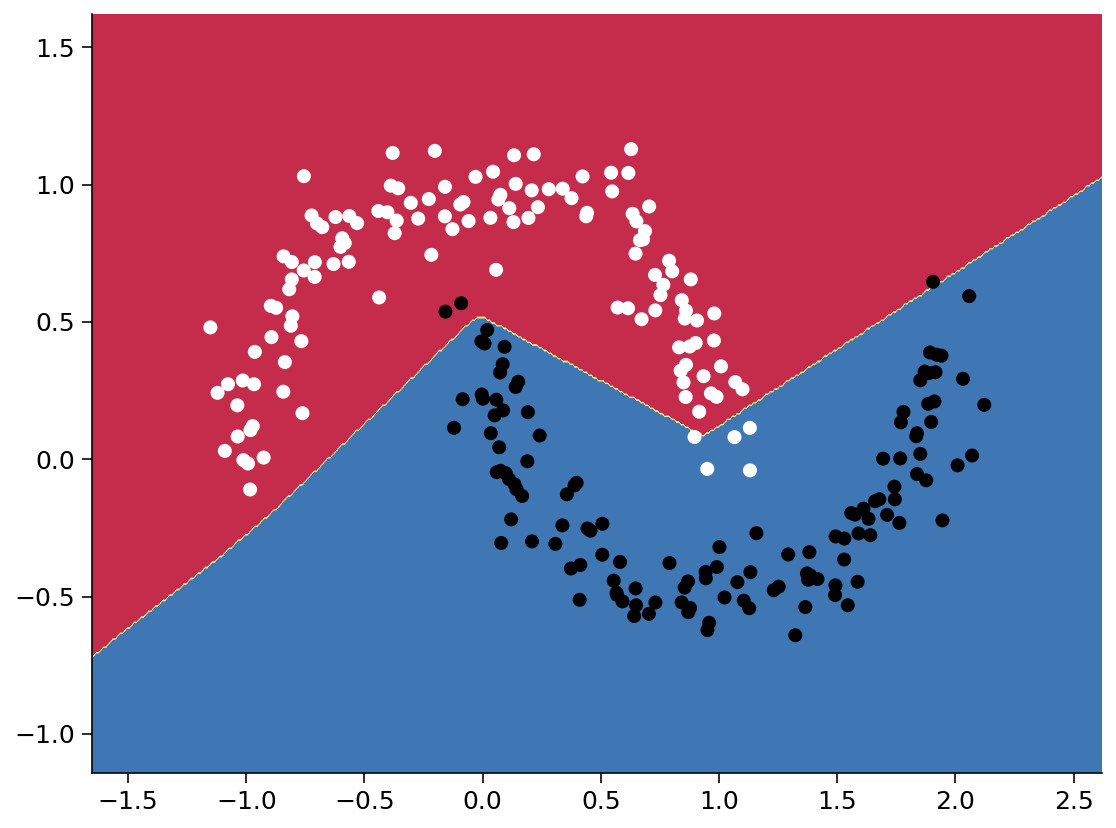

In [104]:
# Implement the train function given a training dataset X and correcsponding labels y
def train(model, X, y):
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 1e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 15000

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    # Pass the data through the network and compute the loss
    # We'll use the whole dataset during the training instead of using batches
    # in to order to keep the code simple for now.
    y_logits = model.forward(X)
    loss = loss_function(y_logits, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results at every 1000th epoch
    if i % 1000 == 0:
      print(f"Epoch {i} loss is {loss.item()}")

      plot_decision_boundary(model, X, y, DEVICE)
      plt.savefig('frames/{:05d}.png'.format(i))

  return losses


# Create a new network instance a train it
model = NaiveNet().to(DEVICE)
losses = train(model, X, y)

**Plot the loss during training**

Plot the loss during the training to see how it reduces and converges.

Text(0, 0.5, 'Loss')

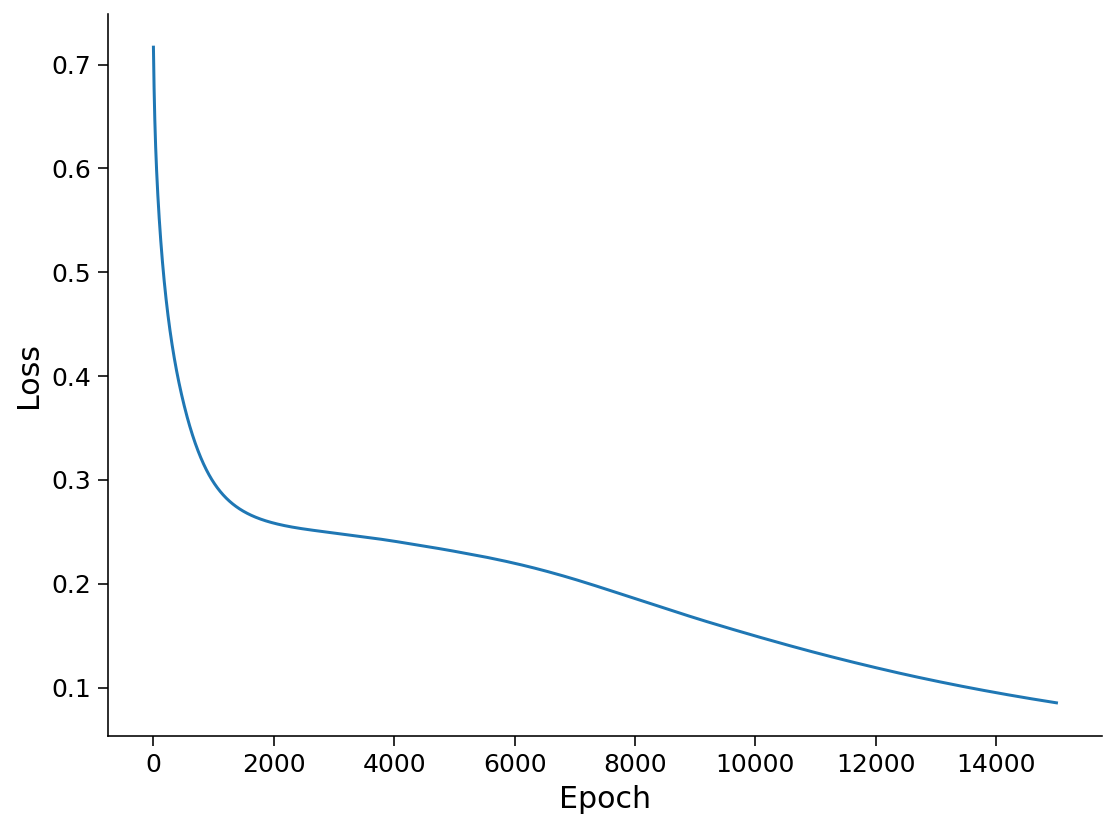

In [105]:
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

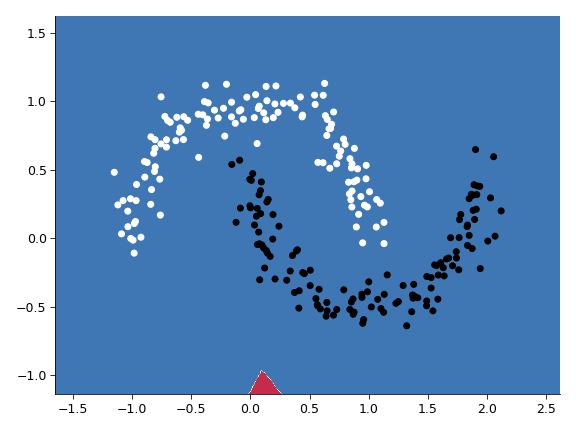

In [106]:
# @title Visualize the training process
# @markdown ### Execute this cell!
!pip install imageio --quiet
!pip install pathlib --quiet

import imageio
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"

# Make a list with all images
images = []
for i in range(10):
  filename = "frames/0"+str(i)+"000.png"
  images.append(imageio.imread(filename))
# Save the gif
imageio.mimsave('frames/movie.gif', images)
gifPath = Path("frames/movie.gif")
with open(gifPath,'rb') as f:
  display(Image(data=f.read(), format='png'))

In [ ]:
# @title Video: Play with it
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Cq4y1W7BH", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"_GGkapdOdSY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 13: Play with it')

display(out)

### Exercise 3.3: Tweak your Network

You can now play around with the network a little bit to get a feeling of what different parameters are doing. Here are some ideas what you could try:
- Increase or decrease the number of epochs for training
- Increase or decrease the size of the hidden layer
- Add one additional hidden layer

Can you get the network to better fit the data?

In [107]:
### @title Video: XOR Widget
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1mB4y1N7QS", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"oTr1nE2rCWg", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add timing to airtable
atform.add_event('Video 14: XOR Widget')

display(out)

Exclusive OR (XOR) logical operation gives a true (`1`) output when the number of true inputs is odd. That is, a true output result if one, and only one, of the inputs to the gate is true. If both inputs are false (`0`) or both are true or false output results. Mathematically speaking, XOR represents the inequality function, i.e., the output is true if the inputs are not alike; otherwise, the output is false.

In case of two inputs ($X$ and $Y$) the following truth table is applied:

\begin{array}{ccc}
X & Y & \text{XOR} \\
\hline
0 & 0 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0 \\
\end{array}

Here, with `0`, we denote `False`, and with `1` we denote `True` in boolean terms.

### Interactive Demo 3.3: Solving XOR

Here we use an open source and famous visualization widget developed by Tensorflow team available [here](https://github.com/tensorflow/playground).
* Play with the widget and observe that you can not solve the continuous XOR dataset.
* Now add one hidden layer with three units, play with the widget, and set weights by hand to solve this dataset perfectly.

For the second part, you should set the weights by clicking on the connections and either type the value or use the up and down keys to change it by one increment. You could also do the same for the biases by clicking on the tiny square to each neuron's bottom left.
Even though there are infinitely many solutions, a neat solution when $f(x)$ is ReLU is: 

\begin{equation}
  y = f(x_1)+f(x_2)-f(x_1+x_2)
\end{equation}

Try to set the weights and biases to implement this function after you played enough :)

In [108]:
# @markdown ###Play with the parameters to solve XOR
from IPython.display import HTML
HTML('<iframe width="1020" height="660" src="https://playground.arashash.com/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.91390&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false" allowfullscreen></iframe>')

/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


---
# Quiz



In [109]:
# @markdown A. Do you think we can solve the discrete XOR (only 4 possibilities) with only 2 hidden units?
w1_min_xor = 'No if we use the two raw features (x1 and x2). It could be solved, though, adding transformations of the input features, such as x1^2 or x1 * x2, but that requires feature engineering and the idea of neural networks is that we learn that automatically.' #@param {type:"string"}

In [110]:
# @markdown B. Can we combine cuda tensors and cpu tensors directly?
different_devices = 'No' #@param {type:"string"}



In [111]:
# @markdown C. Which event gave rise to the new popularity of DL?
# @markdown 1. LeNet
# @markdown 2. Alexnet
# @markdown 3. Facenet
# @markdown 4. Transformers
dl_event = 'Transformers' #@param {type:"string"}



In [112]:
# @markdown D. How can ML hurt people? Choose all that apply.
# @markdown 1. Bad medical decisions
# @markdown 2. Unjust imprisonment
# @markdown 3. Biases
# @markdown 4. It cannot hurt people
# @markdown 5. All of the above

ml_hurtful = '1, 2, 3' #@param {type:"string"}

---
# Wrap Up

In [ ]:
# @title Video: Submission info
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1e44y127ti", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"JwTn7ej2dq8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### TL;DR: Basic tutorial workflow
1.  Work through the tutorial, the code exercises, answer the quiz questions and have a look at the discussion questions.

2. At end each tutorial, run the Airtable submission code cell.

3. Hit the submit button.

4. Fill out the feedback form and submit it via Airtable, too.

### Submission FAQs

1. What if I want to change my answers to previous discussion questions? 
> you are free to change and resubmit any of the answers and Think! questions as many times as you like. However, <b> please only run the airtable submission code and click on the link once you are ready to submit</b>.

2. Okay, but what if I submitted my airtable anyway and reallly want to resubmit?
> After making changes, you can re-run the airtable submission cell code cell. This will result in a second submission from you for the data. This will make Darryl sad as it will be more work for him to clean up the data later. 

3. HELP! I accidentally ran the code to generate the airtable submission button before I was ready to submit! what do I do?
> If you run the code to generate the link, anything that happens afterwards will not be captured. Complete the tutorial and make sure to re-run the airtable submission again when you are finished before pressing the submission button. 
4. What if I want to work on this on my own later, should I wait to submit until I'm finished?
>  Please submit wherever you are by every Monday at 1pm. It's graet that you want to keep working on this, but it's important to see the places where we tried things that didn't quite work out, so we can fix them for next year.  

Finally, we try to keep the airtable code as hidden as possible, but if you ever see any calls to `atform`  such as `atform.add_event()` in the coding exercises, just know that is for saving airtable information only.<b> It will not affect the code that is being run around it in any way</b> , so please do not modify, comment out, or worry about any of those lines of code.
<br><br><br>
Now, lets try submitting today's course to Airtable by running the next cell and clicking the button when it appears. 

### Submission

In [113]:
#@markdown Run cell to show Airtable form
#@markdown **Confirm your answers and then click "Submit"**
import numpy as np
import time
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src

#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: tutorial;
except NameError: tutorial = ""
try: w1_min_xor;
except NameError: w1_min_xor = "Select"
try: different_devices;
except NameError: different_devices = "Select"
try: dl_event;
except NameError: dl_event = "Select"
try: ml_hurtful;
except NameError: ml_hurtful = "Select"
try: repeat_concepts;
except NameError: repeat_concepts = "answer"


times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "email": my_email,
          "tutorial": tutorial,
          "w1_min_xor": w1_min_xor,
          "different_devices": different_devices,
          "dl_event": dl_event,
          "ml_hurtful": ml_hurtful,
          "repeat_concepts": repeat_concepts,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrdS95FZ3wyIe5XH?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

1674575586.091771

'miltondp'

'Factorial Ferrets'

'W1D1'

'No if we use the two raw features (x1 and x2). It could be solved, though, adding transformations of the input features, such as x1^2 or x1 * x2, but that requires feature engineering and the idea of neural networks is that we learn that automatically.'

'No'

'Transformers'

'1, 2, 3'

## Feedback
How could this session have been better? How do you feel right now?

Feel free to use the embeded form below:

In [114]:
#@markdown ##Run cell to show feedback form
#@markdown ####Confirm your answers and then click "Submit"

display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ?backgroundColor=red", width = 800, height = 400))

---
---
# Optional Bonus - 60 years of Machine Learning Research in one Plot

by [Hendrik Strobelt](http://hendrik.strobelt.com) (MIT-IBM Watson AI Lab) with support from Benjamin Hoover.

In this notebook we visualize a subset* of 3,300 articles retreived from the AllenAI [S2ORC dataset](https://github.com/allenai/s2orc). We represent each paper by a position that is output of a dimensionality reduction method applied to a vector representation of each paper. The vector representation is output of a neural network.

*The selection is very biased on the keywords and methodology we used to filter. Please see the details section to learn about what we did. 

In [ ]:
# @title Import `altair` and load the data
!pip install altair vega_datasets --quiet
import requests
import altair as alt # altair is defining data visualizations

# Source data files
# Position data file maps ID to x,y positions
# original link: http://gltr.io/temp/ml_regexv1_cs_ma_citation+_99perc.pos_umap_cosine_100_d0.1.json
POS_FILE = 'https://osf.io/qyrfn/download'
# original link: http://gltr.io/temp/ml_regexv1_cs_ma_citation+_99perc_clean.csv
# Metadata file maps ID to title, abstract, author,....
META_FILE = 'https://osf.io/vfdu6/download'

# data loading and wrangling
def load_data():
  positions = pd.read_json(POS_FILE)
  positions[['x', 'y']] = positions['pos'].to_list()
  meta = pd.read_csv(META_FILE)
  return positions.merge(meta, left_on='id', right_on='paper_id')

# load data
data = load_data()

In [ ]:
# @title Define Visualization using ALtair
YEAR_PERIOD = "quinquennial"  # @param
selection = alt.selection_multi(fields=[YEAR_PERIOD], bind='legend')
data[YEAR_PERIOD] = (data["year"] / 5.0).apply(np.floor) * 5
chart = alt.Chart(data[["x", "y", "authors", "title", YEAR_PERIOD, "citation_count"]], width=800,
                  height=800).mark_circle(radius=2, opacity=0.2).encode(
    alt.Color(YEAR_PERIOD+':O',
              scale=alt.Scale(scheme='viridis', reverse=False, clamp=True, domain=list(range(1955,2020,5))),
              # legend=alt.Legend(title='Total Records')
              ),
    alt.Size('citation_count',
              scale=alt.Scale(type="pow", exponent=1, range=[15, 300])
              ),
       alt.X('x:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
       alt.Y('y:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    tooltip=['title', 'authors'],
    # size='citation_count',
    # color="decade:O",
    opacity=alt.condition(selection, alt.value(.8), alt.value(0.2)),

).add_selection(
    selection
).interactive()

Lets look at the Visualization. Each dot represents one paper. Close dots mean that the respective papers are closer related than distant ones. The color indicates the 5-year period of when the paper was published. The dot size indicates the citation count (within S2ORC corpus) as of July 2020. 

The view is **interactive** and allows for three main interactions. Try them and play around.
1. hover over a dot to see a tooltip (title, author)
2. select a year in the legend (right) to filter dots
2. zoom in/out with scroll -- double click resets view 

In [ ]:
chart

alt.Chart(...)

## Methods

Here is what we did:
1. Filtering of all papers who fullfilled the criterria:
  - are categorized as `Computer Science` or `Mathematics` 
  - one of the following keywords appearing in title or abstract: `"machine learning|artificial intelligence|neural network|(machine|computer) vision|perceptron|network architecture| RNN | CNN | LSTM | BLEU | MNIST | CIFAR |reinforcement learning|gradient descent| Imagenet "`
2. per year, remove all papers that are below the 99 percentile of citation count in that year
3. embed each paper by using abstract+title in SPECTER model
4. project based on embedding using UMAP
5. visualize using Altair

### Find Authors

In [ ]:
# @title Edit the `AUTHOR_FILTER` variable to full text search for authors.

AUTHOR_FILTER = "Rush "  # @param space at the end means "word border"

### Don't ignore case when searching...
FLAGS = 0
### uncomment do ignore case
# FLAGS = re.IGNORECASE

## --- FILTER CODE.. make it your own ---
import re
data['issel'] = data['authors'].str.contains(AUTHOR_FILTER, na=False, flags=FLAGS, )
if data['issel'].mean()<0.0000000001:
  print('No match found')

## --- FROM HERE ON VIS CODE ---
alt.Chart(data[["x", "y", "authors", "title", YEAR_PERIOD, "citation_count", "issel"]], width=800,
                  height=800) \
    .mark_circle(stroke="black", strokeOpacity=1).encode(
    alt.Color(YEAR_PERIOD+':O',
              scale=alt.Scale(scheme='viridis', reverse=False),
              # legend=alt.Legend(title='Total Records')
              ),
    alt.Size('citation_count',
              scale=alt.Scale(type="pow", exponent=1, range=[15, 300])
              ),
    alt.StrokeWidth('issel:Q', scale=alt.Scale(type="linear", domain=[0,1], range=[0, 2]), legend=None),

    alt.Opacity('issel:Q', scale=alt.Scale(type="linear", domain=[0,1], range=[.2, 1]), legend=None),
    alt.X('x:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    alt.Y('y:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    tooltip=['title', 'authors'],
).interactive()

alt.Chart(...)

---
---
# Appendix

## Official PyTorch resources:
### Tutorials
https://pytorch.org/tutorials/

### Documentation

 https://pytorch.org/docs/stable/tensors.html (tensor methods)

 https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view  (The view method in particular)

 https://pytorch.org/vision/stable/datasets.html (pre-loaded image datasets)

 ## Google Colab Resources:
 https://research.google.com/colaboratory/faq.html (FAQ including guidance on GPU usage)

 ## Books for reference:

https://www.deeplearningbook.org/ (Deep Learning by Ian Goodfellow, Yoshua Bengio and Aaron Courville)

 